# Modelo de predicción de éxito de las startups

En este enlace hacen un EDA y depuración de nuestro dataset, nos puede servir como guía:

https://www.kaggle.com/ajaygorkar/eda-startup-success-analysis

## 1. Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
import seaborn as sns

## 2. Importación de datos

In [2]:
import os
current_path = os.getcwd() #obtener la ruta donde se guarda este cuaderno
dataset_path =current_path+'/startups_data.csv' #obtener la ruta donde se guarda el conjunto de datos de startups

In [3]:
original_df=pd.read_csv(dataset_path, na_values=['none','None'])

##JM: le agregué para convertir los None y none a NA.

## 3. Análisis exploratorio inicial

In [4]:
original_df.head()

,Company_Name,Dependent-Company Status,year of founding,Age of company in years,Internet Activity Score,Short Description of company profile,Industry of company,Focus functions of company,Investors,Employee Count,Employees count MoM change,Has the team size grown,Est. Founding Date,Last Funding Date,Last Funding Amount,Country of company,Continent of company,Number of Investors in Seed,Number of Investors in Angel and or VC,Number of Co-founders,Number of of advisors,Team size Senior leadership,Team size all employees,Presence of a top angel or venture fund in previous round of investment,Number of of repeat investors,Number of Sales Support material,Worked in top companies,Average size of companies worked for in the past,Have been part of startups in the past?,Have been part of successful startups in the past?,Was he or she partner in Big 5 consulting?,Consulting experience?,Product or service company?,Catering to product/service across verticals,Focus on private or public data?,Focus on consumer data?,Focus on structured or unstructured data,Subscription based business,Cloud or platform based serive/product?,Local or global player,Linear or Non-linear business model,"Capital intensive business e.g. e-commerce, Engineering products and operations can also cause a business to be capital intensive",Number of of Partners of company,Crowdsourcing based business,Crowdfunding based business,Machine Learning based business,Predictive Analytics business,Speech analytics business,Prescriptive analytics business,Big Data Business,Cross-Channel Analytics/ marketing channels,Owns data or not? (monetization of data) e.g. Factual,Is the company an aggregator/market place? e.g. Bluekai,Online or offline venture - physical location based business or online venture?,B2C or B2B venture?,Top forums like 'Tech crunch' or 'Venture beat' talking about the company/model - How much is it being talked about?,Average Years of experience for founder and co founder,Exposure across the globe,Breadth of experience across verticals,Highest education,Years of education,Specialization of highest education,Relevance of education to venture,Relevance of experience to venture,Degree from a Tier 1 or Tier 2 university?,Renowned in professional circle,Experience in selling and building products,Experience in Fortune 100 organizations,Experience in Fortune 500 organizations,Experience in Fortune 1000 organizations,Top management similarity,Number of Recognitions for Founders and Co-founders,Number of of Research publications,Skills score,Team Composition score,Dificulty of Obtaining Work force,Pricing Strategy,Hyper localisation,Time to market service or product,Employee benefits and salary structures,Long term relationship with other founders,Proprietary or patent position (competitive position),Barriers of entry for the competitors,Company awards,Controversial history of founder or co founder,Legal risk and intellectual property,Client Reputation,google page rank of company website,Technical proficiencies to analyse and interpret unstructured data,Solutions offered,Invested through global incubation competitions?,Industry trend in investing,Disruptiveness of technology,Number of Direct competitors,Employees per year of company existence,Last round of funding received (in milionUSD),"Survival through recession, based on existence of the company through recession times",Time to 1st investment (in months),"Avg time to investment - average across all rounds, measured from previous investment",Gartner hype cycle stage,Time to maturity of technology (in years),Percent_skill_Entrepreneurship,Percent_skill_Operations,Percent_skill_Engineering,Percent_skill_Marketing,Percent_skill_Leadership,Percent_skill_Data Science,Percent_skill_Business Strategy,Percent_skill_Product Management,Percent_skill_Sales,Percent_skill_Domain,Percent_skill_Law,Percent_skill_Consulting,Percent_skill_Finance,Percent_skill_Investment,Renown score
0,Company1,Success,No Info,No Info,-1.0,Video di

In [5]:
len(original_df)

472

In [6]:
len(original_df.columns)

116

El dataset tiene 116 columnas y 472 filas

### Distribución de la variable target

Hacer gráficos para ver cómo de desbalanceada está la variable target, gráficos de las variables categóricas, de correlaciones... todo lo que se nos ocurra que pueda interesar

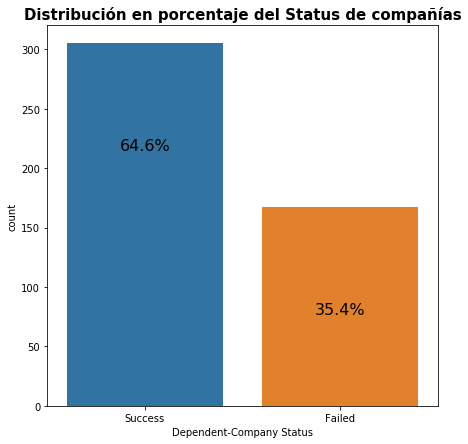

In [7]:
# Analizamos la variable dependiente -> 'Dependent-Company Status'
plt.figure(figsize=(7,7))
plt.title("Distribución en porcentaje del Status de compañías",{'fontweight':"bold",'fontsize':15})

plt.xlabel("Status de las compañías")
plt.ylabel("Cantidad de compañías")

countx = sns.countplot(original_df["Dependent-Company Status"])
sumatoria = []
for i in countx.patches:
    sumatoria.append(i.get_height())
total = sum(sumatoria)

for i in countx.patches:
    countx.text(i.get_x()+0.27, i.get_height()-90, \
            str(round((i.get_height()/total)*100,1))+'%', fontsize=16)


- El 64.6% de las empresas han tenido éxito y el 35.4% han fracasado, podríamos inferir que el dataset está equilibrado en referencia a la distribución de la variable target.

## 4. Procesamiento previo de los datos

### Eliminación de variables no informativas

Eliminamos variables que no van a aportar nada al modelo (por ej. variables identificadoras):

- Company name: variable identificadora
- Short Description of company profile: descripción de la empresa, es texto libre (difícil de manejar) y su información relevante viene recogida en otras variables
- Investors: variable que contiene el nombre de los inversionistas, tenemos datos de inversionistas más relevantes en otras variables, como por ejemplo el número de inversionistas en el origen

In [8]:
df_var_elim=original_df.drop(['Company_Name','Short Description of company profile', 'Investors'], axis=1) 

#JM: eliminé también Investors

### Renombrado de columnas 

Renombramos las columnas a nombres más cortos y sin espacios para una manipulación más fácil

In [9]:
df_var_elim.rename(columns={'Dependent-Company Status': 'status',
                                       'year of founding': 'fundation_year',
                                       'Age of company in years': 'age_years',
                                       'Internet Activity Score': 'internet_score',
                                       'Industry of company': 'industry',
                                       'Focus functions of company': 'focus_functions',
                                       'Investors': 'investors',
                                       'Employee Count':'count_employee',
                                       'Employees count MoM change': 'count_employee_MoM_change',
                                       'Has the team size grown': 'has_team_size_grown',
                                       'Est. Founding Date':'est_founding_date',
                                       'Last Funding Date': 'last_funding_date',
                                       'Last Funding Amount':'last_funding_amount',
                                       'Country of company':'country',
                                       'Continent of company':'continent',
                                       'Number of Investors in Seed':'number_investors_seed',
                                        'Number of Investors in Angel and or VC': 'number_investors_angel_VC',
                                        'Number of Co-founders':'number_cofounders',
                                        'Number of of advisors':'number_advisors',
                                        'Team size Senior leadership':'team_size_senior_lead',
                                        'Team size all employees':'team_size_all_employees',
                                        'Presence of a top angel or venture fund in previous round of investment':'presence_angel_venture_fund',
                                        'Number of of repeat investors':'number_repeat_investors',
                                        'Number of  Sales Support material':'number_sales_support_material',
                                        'Worked in top companies':'worked_top_company',
                                        'Average size of companies worked for in the past':'avg_size_companies_worked_for_past',
                                        'Have been part of startups in the past?':'part_of_startups_past',
                                        'Have been part of successful startups in the past?':'part_of_success_startups_past',
                                        'Was he or she partner in Big 5 consulting?':'partner_big5_consulting',
                                        'Consulting experience?':'consulting_experience',
                                        'Product or service company?':'product_or_service_company',
                                        'Catering to product/service across verticals':'catering_product_service_across_verticals',
                                        'Focus on private or public data?' :'focus_private_or_public_data',
                                        'Focus on consumer data?':'focus_consumer_data',
                                        'Focus on structured or unstructured data' :'focus_structured_unstructured_data',
                                        'Subscription based business':'subscription_based',
                                        'Cloud or platform based serive/product?' :'cloud_or_platform_based',
                                        'Local or global player':'local_or_global_player',
                                        'Linear or Non-linear business model':'linear_nonlinear_business',
                                        'Capital intensive business e.g. e-commerce, Engineering products and operations can also cause a business to be capital intensive':'capital_intensive',
                                        'Number of  of Partners of company' :'number_partners',
                                        'Crowdsourcing based business':'crowdsourcing_business',
                                        'Crowdfunding based business':'crowdfunding_business',
                                        'Machine Learning based business':'ML_business',
                                        'Predictive Analytics business':'predictive_analytics_business',
                                        'Speech analytics business':'speech_analytics_business',
                                        'Prescriptive analytics business' :'prescriptive_analytics_business',
                                        'Big Data Business':'big_data_business',
                                        'Cross-Channel Analytics/ marketing channels':'cross_channel_analytics_or_marketing',
                                        'Owns data or not? (monetization of data) e.g. Factual':'owns_data',
                                        'Is the company an aggregator/market place? e.g. Bluekai':'aggregator_or_market_place',
                                        'Online or offline venture - physical location based business or online venture?':'online_or_offline_business',
                                        'B2C or B2B venture?':'B2C_or_B2B',
                                        "Top forums like 'Tech crunch' or 'Venture beat' talking about the company/model - How much is it being talked about?":'top_forums_talking_about_company',
                                        'Average Years of experience for founder and co founder':'avg_years_experience for founder and co founder',
                                        'Exposure across the globe':'exposure_across_globe',
                                        'Breadth of experience across verticals':'breadth_experience_across_verticals',
                                        'Highest education' :'highest_education',
                                        'Years of education':'years_education',
                                        'Specialization of highest education':'specialization_highest_education',
                                        'Relevance of education to venture':'relevance_education_venture',
                                        'Relevance of experience to venture':'relevance_experience_venture',
                                        'Degree from a Tier 1 or Tier 2 university?':'degree_tier1_tier2_university',
                                        'Renowned in professional circle':'renowned_professional_circle',
                                        'Experience in selling and building products':'experience_selling_building_products',
                                        'Experience in Fortune 100 organizations':'experience_fortune_100_organizations',
                                        'Experience in Fortune 500 organizations':'experience_fortune_500_organizations',
                                        'Experience in Fortune 1000 organizations' :'experience_fortune_1000_organizations',
                                        'Top management similarity':'top_management_similarity',
                                        'Number of Recognitions for Founders and Co-founders':'number_recognitions_for_founders_cofounders',
                                        'Number of  of Research publications':'number_research_publications',
                                        'Skills score':'skills_score',
                                        'Team Composition score':'team_composition_score',
                                        'Dificulty of Obtaining Work force':'difficulty_obtain_workforce',
                                        'Pricing Strategy' :'pricing_strategy',
                                        'Hyper localisation':'hyper_localisation',
                                        'Time to market service or product':'time_market_service_product',
                                        'Employee benefits and salary structures':'employee_benefits_salary_structures',
                                        'Long term relationship with other founders':'long_term_relation_other_founders',
                                        'Proprietary or patent position (competitive position)':'proprietary_patent_position',
                                        'Barriers of entry for the competitors':'barriers_entry_competitors',
                                        'Company awards':'company_awards',
                                        'Controversial history of founder or co founder':'controversial_history_founder_cofounder',
                                        'Legal risk and intellectual property' :'legal_risk_intell_property',
                                        'Client Reputation':'client_reputation',
                                        'google page rank of company website':'google_page_rank_company_web',
                                        'Technical proficiencies to analyse and interpret unstructured data':'technical_skills_analyse_unstructured_data',
                                        'Solutions offered' :'solutions_offered',
                                        'Invested through global incubation competitions?':'invested_through_global_incubation_competitions',
                                        'Industry trend in investing' :'industry_trend_investing',
                                        'Disruptiveness of technology':'disruptiveness_technology',
                                        'Number of Direct competitors' :'number_direct_competitors',
                                        'Employees per year of company existence':'employees_per_year_existence',
                                        'Last round of funding received (in milionUSD)':'last_round_fundind_millionUSD',
                                        'Survival through recession, based on existence of the company through recession times':'survival_through_recession',
                                        'Time to 1st investment (in months)':'months_to_1st_investment',
                                        'Avg time to investment - average across all rounds, measured from previous investment':'avg_time_to_investment',
                                        'Gartner hype cycle stage':'gartner_hype_cycle_stage',
                                        'Time to maturity of technology (in years)':'time_maturity_technology',
                                        'Percent_skill_Entrepreneurship' :'perc_skill_entrepreneur',
                                        'Percent_skill_Operations':'perc_skill_operations',
                                        'Percent_skill_Engineering':'perc_skill_engineering', 
                                        'Percent_skill_Marketing':'perc_skill_marketing',
                                        'Percent_skill_Leadership' :'perc_skill_leadership',
                                        'Percent_skill_Data Science':'perc_skill_datascience',
                                        'Percent_skill_Business Strategy' :'perc_skill_business_strategy',
                                        'Percent_skill_Product Management':'perc_skill_product_manag',
                                        'Percent_skill_Sales' :'perc_skill_sales',
                                        'Percent_skill_Domain' :'perc_skill_domain',
                                        'Percent_skill_Law':'perc_skill_law',
                                        'Percent_skill_Consulting' :'perc_skill_consulting',
                                        'Percent_skill_Finance':'perc_skill_finance',
                                        'Percent_skill_Investment':'perc_skill_investment',
                                        'Renown score':'renown_score'
                        },inplace=True) 

In [10]:
df_var_elim.columns

Index(['status', 'fundation_year', 'age_years', 'internet_score', 'industry',
       'focus_functions', 'count_employee', 'count_employee_MoM_change',
       'has_team_size_grown', 'est_founding_date',
       ...
       'perc_skill_datascience', 'perc_skill_business_strategy',
       'perc_skill_product_manag', 'perc_skill_sales', 'perc_skill_domain',
       'perc_skill_law', 'perc_skill_consulting', 'perc_skill_finance',
       'perc_skill_investment', 'renown_score'],
      dtype='object', length=113)

### Replace missing values by NA

Detecto missings para poder transformar las variables al tipo adecuado. Por ejemplo, aquellas que en realidad son numéricas pero tienen la categoría 'No Info' en lugar de NA, necesitan cambiar dicho string a NA para que sea posible su paso a numéricas. Posteriormente imputaremos los NA.

**Variables que aparecen como numéricas**

La función describe nos permite ver si hay valores erróneos, y en ese caso, los sustituimos por NA:

In [11]:
df_var_elim.describe() 

,internet_score,count_employee,count_employee_MoM_change,last_funding_amount,number_cofounders,number_advisors,team_size_senior_lead,industry_trend_investing
count,407.000000,306.000000,267.000000,3.120000e+02,472.000000,472.000000,472.000000,390.000000
mean,114.159705,31.408497,-1.299625,6.379489e+06,1.868644,1.016949,3.730932,2.889744
std,225.651419,62.673600,23.967085,9.901622e+06,1.143481,2.014736,2.516539,0.845765
min,-725.000000,0.000000,-100.000000,1.000000e+04,0.000000,0.000000,1.000000,0.000000
25%,-3.500000,4.250000,0.000000,7.500000e+05,1.000000,0.000000,2.000000,2.000000
50%,60.000000,13.000000,0.000000,2.800000e+06,2.000000,0.000000,3.000000,3.000000
75%,216.000000,31.000000,6.000000,7.850000e+06,2.250000,1.000000,5.000000,3.000000
max,1535.000000,594.000000,50.000000,7.700000e+07,7.000000,13.000000,24.000000,5.000000


Como vemos, las variable internet_score, count_employee_MoM_change tienen valores negativos y no deberían: ponemos como NA los <0

In [12]:
df_with_na=df_var_elim

for x in ['internet_score', 'count_employee_MoM_change']:
    
    df_with_na[x] = df_var_elim[x].map(lambda item : np.nan if item < 0 else item)

**Variables que aparecen como categóricas**

Miro las categorías distintas (unique) de las variables que vienen como categóricas para detectar los missings y ponerlos como NA:

In [13]:
cols=df_with_na.select_dtypes(include="object")
for col in cols:
    print(col)
    print("="*80)
    unique=df_with_na[col].unique()
    print(unique)
    print("="*80)

status
['Success' 'Failed']
fundation_year
['No Info' '2011' '2009' '2010' '2013' '2008' '2002' '2005' '2012' '2007'
 '2003' '2000' '2006' '1999' '2004' '1997']
age_years
['No Info' '3' '5' '4' '1' '6' '12' '9' '2' '7' '11' '14' '8' '15' '10'
 nan '17']
industry
[nan 'Market Research|Marketing|Crowdfunding'
 'Analytics|Cloud Computing|Software Development' 'Mobile|Analytics'
 'Analytics|Marketing|Enterprise Software' 'Food & Beverages|Hospitality'
 'Analytics' 'Cloud Computing|Network / Hosting / Infrastructure'
 'Analytics|Mobile|Marketing' 'Healthcare|Pharmaceuticals|Analytics'
 'Analytics|Enterprise Software' 'Media|Finance|Marketing'
 'Music|Analytics' 'E-Commerce|Gaming|Analytics' 'Healthcare|Analytics'
 'Marketing' 'Advertising|Retail|Mobile' 'Mobile|Retail'
 'Analytics|Finance' 'Software Development'
 'Marketing|Software Development|Analytics' 'Security' 'Advertising'
 'Marketing|Email' 'Analytics|Security|Network / Hosting / Infrastructure'
 'Human Resources (HR)|Marketing|Care

Observamos que las siguientes variables numéricas (o tipo fecha) tienen asignado tipo 'object' porque tienen la categoría 'No Info' (la última de la lista, adicionalmente, tiene la categoría 'unknown amount'):

In [14]:
replace_no_info=['fundation_year',
'age_years',
'number_investors_seed',
'number_investors_angel_VC',
'team_size_all_employees',
'number_repeat_investors',
'years_education',
'renowned_professional_circle',
'number_recognitions_for_founders_cofounders',
'skills_score',
'google_page_rank_company_web',
'number_direct_competitors',
'employees_per_year_existence',
'months_to_1st_investment',
'avg_time_to_investment',
'perc_skill_entrepreneur',
'perc_skill_operations',
'perc_skill_engineering',
'perc_skill_marketing',
'perc_skill_leadership',
'perc_skill_datascience',
'perc_skill_business_strategy',
'perc_skill_product_manag',
'perc_skill_sales',
'perc_skill_domain',
'perc_skill_law',
'perc_skill_consulting',
'perc_skill_finance',
'perc_skill_investment',
'renown_score',
'last_round_fundind_millionUSD',#tambien unknown_amount
'est_founding_date',
'last_funding_date'] 

Reemplazamos dichos missings por NA:

In [15]:
for col in replace_no_info:

    df_with_na[col] = df_with_na[col].map(lambda item : np.nan if item == 'No Info' else item)

df_with_na['last_round_fundind_millionUSD']=df_with_na['last_round_fundind_millionUSD'].map(lambda item : np.nan if item == 'unknown amount' else item)

Comprobamos que han sido correctamente reemplazados:

In [16]:
cols=df_with_na.select_dtypes(include="object")
for col in cols:
    print(col)
    print("="*80)
    unique=df_with_na[col].unique()
    print(unique)
    print("="*80)

status
['Success' 'Failed']
fundation_year
[nan '2011' '2009' '2010' '2013' '2008' '2002' '2005' '2012' '2007' '2003'
 '2000' '2006' '1999' '2004' '1997']
age_years
[nan '3' '5' '4' '1' '6' '12' '9' '2' '7' '11' '14' '8' '15' '10' '17']
industry
[nan 'Market Research|Marketing|Crowdfunding'
 'Analytics|Cloud Computing|Software Development' 'Mobile|Analytics'
 'Analytics|Marketing|Enterprise Software' 'Food & Beverages|Hospitality'
 'Analytics' 'Cloud Computing|Network / Hosting / Infrastructure'
 'Analytics|Mobile|Marketing' 'Healthcare|Pharmaceuticals|Analytics'
 'Analytics|Enterprise Software' 'Media|Finance|Marketing'
 'Music|Analytics' 'E-Commerce|Gaming|Analytics' 'Healthcare|Analytics'
 'Marketing' 'Advertising|Retail|Mobile' 'Mobile|Retail'
 'Analytics|Finance' 'Software Development'
 'Marketing|Software Development|Analytics' 'Security' 'Advertising'
 'Marketing|Email' 'Analytics|Security|Network / Hosting / Infrastructure'
 'Human Resources (HR)|Marketing|Career / Job Search'


### Asignar tipo de datos correcto

Una vez sustituidos los missings por NA, podemos asignar a las variables su tipo adecuado de datos.

Hay muchas columnas que aparecen como *object* pero en realidad son numéricas, y dos de ellas que aparecen como *object* pero son de tipo *datetime* ('est_founding_date','last_funding_date'). 

Vemos el tipo de datos asignado a cada columna:

In [17]:
type_data=pd.DataFrame(df_with_na.dtypes,columns=["Data Types"]) 

In [18]:
type_data

,Data Types
status,object
fundation_year,object
age_years,object
internet_score,float64
industry,object
focus_functions,object
count_employee,float64
count_employee_MoM_change,float64
has_team_size_grown,object
est_founding_date,object


Separamos las columnas que tienen que transformarse a numéricas (las transformamos a *float*) y a tipo fecha (*datetime*)

In [19]:
transform_to_float=['number_cofounders',
                    'number_advisors',
                    'team_size_senior_lead',
                    'fundation_year',
                    'age_years',
                    'number_investors_seed',
                    'number_investors_angel_VC',
                    'team_size_all_employees',
                    'number_repeat_investors',
                    'years_education',
                    'renowned_professional_circle',
                    'number_recognitions_for_founders_cofounders',
                    'skills_score',
                    'google_page_rank_company_web',
                    'number_direct_competitors',
                    'employees_per_year_existence',
                    'months_to_1st_investment',
                    'avg_time_to_investment',
                    'perc_skill_entrepreneur',
                    'perc_skill_operations',
                    'perc_skill_engineering',
                    'perc_skill_marketing',
                    'perc_skill_leadership',
                    'perc_skill_datascience',
                    'perc_skill_business_strategy',
                    'perc_skill_product_manag',
                    'perc_skill_sales',
                    'perc_skill_domain',
                    'perc_skill_law',
                    'perc_skill_consulting',
                    'perc_skill_finance',
                    'perc_skill_investment',
                    'renown_score',
                    'last_round_fundind_millionUSD']


transform_to_date=['est_founding_date','last_funding_date']

Transformamos cada variable a su formato adecuado:

In [20]:
df_correct_type=df_with_na

for col in transform_to_float:

    df_correct_type[col]=df_correct_type[col].astype(float)
    
for col in transform_to_date:

    df_correct_type[col]=pd.to_datetime(df_correct_type[col])

Comprobamos si se ha cambiado el tipo de dato correctamente:

In [21]:
type_data=pd.DataFrame(df_correct_type.dtypes,columns=["Data Types"]) #ver tipo de datos

In [22]:
type_data

,Data Types
status,object
fundation_year,float64
age_years,float64
internet_score,float64
industry,object
focus_functions,object
count_employee,float64
count_employee_MoM_change,float64
has_team_size_grown,object
est_founding_date,datetime64[ns]


In [23]:
df_correct_type.head()

,status,fundation_year,age_years,internet_score,industry,focus_functions,count_employee,count_employee_MoM_change,has_team_size_grown,est_founding_date,last_funding_date,last_funding_amount,country,continent,number_investors_seed,number_investors_angel_VC,number_cofounders,number_advisors,team_size_senior_lead,team_size_all_employees,presence_angel_venture_fund,number_repeat_investors,number_sales_support_material,worked_top_company,avg_size_companies_worked_for_past,part_of_startups_past,part_of_success_startups_past,partner_big5_consulting,consulting_experience,product_or_service_company,catering_product_service_across_verticals,focus_private_or_public_data,focus_consumer_data,focus_structured_unstructured_data,subscription_based,cloud_or_platform_based,local_or_global_player,linear_nonlinear_business,capital_intensive,number_partners,crowdsourcing_business,crowdfunding_business,ML_business,predictive_analytics_business,speech_analytics_business,prescriptive_analytics_business,big_data_business,cross_channel_analytics_or_marketing,owns_data,aggregator_or_market_place,online_or_offline_business,B2C_or_B2B,top_forums_talking_about_company,avg_years_experience for founder and co founder,exposure_across_globe,breadth_experience_across_verticals,highest_education,years_education,specialization_highest_education,relevance_education_venture,relevance_experience_venture,degree_tier1_tier2_university,renowned_professional_circle,experience_selling_building_products,experience_fortune_100_organizations,experience_fortune_500_organizations,experience_fortune_1000_organizations,top_management_similarity,number_recognitions_for_founders_cofounders,number_research_publications,skills_score,team_composition_score,difficulty_obtain_workforce,pricing_strategy,hyper_localisation,time_market_service_product,employee_benefits_salary_structures,long_term_relation_other_founders,proprietary_patent_position,barriers_entry_competitors,company_awards,controversial_history_founder_cofounder,legal_risk_intell_property,client_reputation,google_page_rank_company_web,technical_skills_analyse_unstructured_data,solutions_offered,invested_through_global_incubation_competitions,industry_trend_investing,disruptiveness_technology,number_direct_competitors,employees_per_year_existence,last_round_fundind_millionUSD,survival_through_recession,months_to_1st_investment,avg_time_to_investment,gartner_hype_cycle_stage,time_maturity_technology,perc_skill_entrepreneur,perc_skill_operations,perc_skill_engineering,perc_skill_marketing,perc_skill_leadership,perc_skill_datascience,perc_skill_business_strategy,perc_skill_product_manag,perc_skill_sales,perc_skill_domain,perc_skill_law,perc_skill_consulting,perc_skill_finance,perc_skill_investment,renown_score
0,Success,NaN,NaN,NaN,NaN,operation,3.0,0.0,No,NaT,2013-05-26,450000.0,United States,North America,2.0,0.0,1.0,2.0,2.0,15.0,Yes,4.0,Nothing,No,Small,No,No,No,No,Service,No,Private,No,Both,Yes,Platform,Global,Linear,Yes,NaN,No,No,No,No,No,No,No,No,No,Yes,Online,B2C,High,High,Yes,Low,Masters,21.0,business,Yes,Yes,Tier_1,500.0,Medium,0,0,0,NaN,0.0,NaN,0.0,Low,Low,Yes,No,High,No Info,No,No,Yes,No,No,No,No Info,9626884.0,No,Yes,No,2.0,Low,0.0,1.500000,0.45,No Info,NaN,11.560000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Success,2011.0,3.0,125.0,Market Research|Marketing|Crowdfunding,"Marketing, sales",NaN,NaN,No,NaT,NaT,NaN,United States,North America,5.0,0.0,2.0,0.0,4.0,20.0,No,0.0,medium,Yes,Large,Yes,Yes,No,No,Product,No,Public,Yes,Both,No,Platform,Local,Non-Linear,No,Few,Yes,No,Yes,Yes,No,No,Yes,Yes,Yes,No,Online,B2C,Low,High,Yes,High,Masters,21.0,Supply Chain Management & Entrepreneurship,Yes,Yes,Tier_1,500.0,High,0,0,0,Medium,13.0,NaN,34.0,High,Medium,Yes,No,Low,No Info,No,Yes,Yes,No,No,Yes,Medium,1067034.0,Yes,Yes,No,3.0,Medium,0.0,6.666667,5.00,Not Applicable,10.0,9.000000,Trough,2 to 5,15.882353,11.764706,15.000000,12.941176,0.0,8.823529,21.7647

### Imputar NA

Ahora, imputamos los valores NA para que no haya problemas al introducirlos en el modelo. 

Decidimos imputar los NA de las variables numéricas con la media:

In [24]:
df_imputed=df_correct_type

cols_numeric=df_imputed.select_dtypes(include=["float64"]).columns

for col in cols_numeric:
    
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mean())

Para las variables tipo fecha, imputamos los missing con la fecha 1700-01-01:

In [25]:
cols_date=['est_founding_date','last_funding_date']

In [26]:
for col in cols_date:

    df_imputed[col].fillna(datetime(1700, 1, 1), inplace=True)

Para las variables tipo *object*, sustituimos los NA por la categoría 'No Info':

In [27]:
cols_object=df_imputed.select_dtypes(include=["object"]).columns

for col in cols_object:

    df_imputed[col] = df_imputed[col].fillna('No Info')


### Codificación y re-agrupación de variables categóricas

**Corección de categorías mal escritas**

In [28]:
cols=df_imputed.select_dtypes(include="object")
for col in cols:
    print(col)
    print("="*80)
    unique=df_imputed[col].unique()
    print(unique)
    print("="*80)

status
['Success' 'Failed']
industry
['No Info' 'Market Research|Marketing|Crowdfunding'
 'Analytics|Cloud Computing|Software Development' 'Mobile|Analytics'
 'Analytics|Marketing|Enterprise Software' 'Food & Beverages|Hospitality'
 'Analytics' 'Cloud Computing|Network / Hosting / Infrastructure'
 'Analytics|Mobile|Marketing' 'Healthcare|Pharmaceuticals|Analytics'
 'Analytics|Enterprise Software' 'Media|Finance|Marketing'
 'Music|Analytics' 'E-Commerce|Gaming|Analytics' 'Healthcare|Analytics'
 'Marketing' 'Advertising|Retail|Mobile' 'Mobile|Retail'
 'Analytics|Finance' 'Software Development'
 'Marketing|Software Development|Analytics' 'Security' 'Advertising'
 'Marketing|Email' 'Analytics|Security|Network / Hosting / Infrastructure'
 'Human Resources (HR)|Marketing|Career / Job Search'
 'Cloud Computing|Healthcare|E-Commerce'
 'Media|Analytics|Publishing|Mobile|Education' 'E-Commerce|Energy|Media'
 'Media|Analytics' 'E-Commerce|Analytics'
 'E-Commerce|Advertising|Analytics' 'Enterprise

In [29]:
df_cat_correct=df_imputed

df_cat_correct['has_team_size_grown'].replace(['yes','YES'],'Yes',inplace=True)

df_cat_correct['focus_private_or_public_data'].replace(['no'],'No Info',inplace=True)

df_cat_correct['focus_structured_unstructured_data'].replace(['no'],'No Info',inplace=True)

df_cat_correct['cloud_or_platform_based'].replace(['cloud'],'Cloud',inplace=True)

df_cat_correct['local_or_global_player'].replace(['global','GLOBAL','GLObaL'],'Global',inplace=True)

df_cat_correct['local_or_global_player'].replace(['local','LOCAL','local  '],'Local',inplace=True)

Comprobamos que se han codificado correctamente:

In [30]:
cols=df_cat_correct.select_dtypes(include="object")
for col in cols:
    print(col)
    print("="*80)
    unique=df_cat_correct[col].unique()
    print(unique)
    print("="*80)

status
['Success' 'Failed']
industry
['No Info' 'Market Research|Marketing|Crowdfunding'
 'Analytics|Cloud Computing|Software Development' 'Mobile|Analytics'
 'Analytics|Marketing|Enterprise Software' 'Food & Beverages|Hospitality'
 'Analytics' 'Cloud Computing|Network / Hosting / Infrastructure'
 'Analytics|Mobile|Marketing' 'Healthcare|Pharmaceuticals|Analytics'
 'Analytics|Enterprise Software' 'Media|Finance|Marketing'
 'Music|Analytics' 'E-Commerce|Gaming|Analytics' 'Healthcare|Analytics'
 'Marketing' 'Advertising|Retail|Mobile' 'Mobile|Retail'
 'Analytics|Finance' 'Software Development'
 'Marketing|Software Development|Analytics' 'Security' 'Advertising'
 'Marketing|Email' 'Analytics|Security|Network / Hosting / Infrastructure'
 'Human Resources (HR)|Marketing|Career / Job Search'
 'Cloud Computing|Healthcare|E-Commerce'
 'Media|Analytics|Publishing|Mobile|Education' 'E-Commerce|Energy|Media'
 'Media|Analytics' 'E-Commerce|Analytics'
 'E-Commerce|Advertising|Analytics' 'Enterprise

### Estudio Univariable

#### internet_score: especifica la actividad de las startups en Internet

Text(0.5, 1.0, 'Actividad de las startups en Internet - Empresas exitosas')

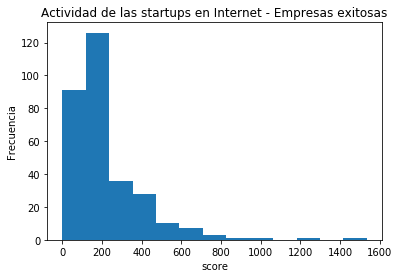

In [62]:
k = int(np.ceil(1+np.log2(3333)))
sub_success = df_cat_correct[df_cat_correct["status"]=="Success"]

plt.hist(sub_success["internet_score"], bins = k)
plt.xlabel("score")
plt.ylabel("Frecuencia")
plt.title("Actividad de las startups en Internet - Empresas exitosas")


Según la distribución de la actividad en internet de las empresas exitosas, tienen un puntaje que oscilan entre 0 y 1600 aproximadamente.

Text(0.5, 1.0, 'Actividad de las startups en Internet - Empresas con fracaso')

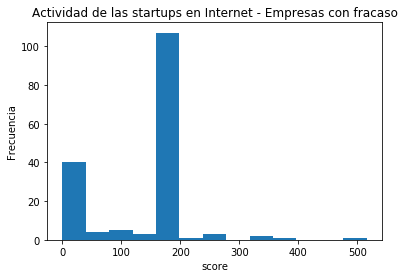

In [63]:
k = int(np.ceil(1+np.log2(3333)))

sub_failed = df_cat_correct[df_cat_correct["status"]=="Failed"]

plt.hist(sub_failed["internet_score"], bins = k)
plt.xlabel("score")
plt.ylabel("Frecuencia")
plt.title("Actividad de las startups en Internet - Empresas con fracaso")

Por otro lado, la puntuación de las empresas que tuvieron fracaso tiene una puntuación de actividad en Internet baja con respecto a las exitosas, estas oscilan entre 0 y 500. Podríamos decir que sus estrategias de marketing online no son suficientes.
Podemos inferir que las empresas que no tienen buenas estrategias de marketing online tienen altas probabilidades de fracasar.

#### big_data_business: negocio enfocado al sector del Big Data

In [72]:
pd.crosstab(index=df_cat_correct["big_data_business"], columns=df_cat_correct["status"]
           ).apply(lambda i: i/i.sum() *100,
                                axis=0)

status,Failed,Success
big_data_business,,
No,79.041916,39.016393
No Info,2.994012,0.000000
Yes,17.964072,60.983607


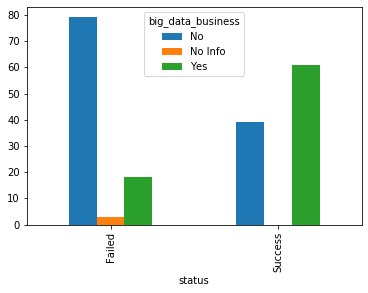

In [73]:
plot = pd.crosstab(index=df_cat_correct["status"],
            columns=df_cat_correct["big_data_business"]).apply(lambda i: i/i.sum() *100,
                                              axis=1).plot(kind='bar')


De acuerdo a la tabla de porcentaje relativos en relación al total de cada estado final de las empresas (éxito o fracaso) y al gráfico de barras que lo acompaña, podemos decir que el 79% de las empresas que fracasan no tienen como principal negocio el análisis de datos fracasan, mientras que el 61% de las empresas que tienen éxito si tienen como giro de negocio el big data. Por lo tanto, podemos inferir que si un negocio se basa en el análisis de data tienen más posibilidades de tener éxito.

In [76]:
pd.crosstab(index=df_cat_correct["count_employee"], columns=df_cat_correct["status"]
           ).apply(lambda i: i/i.sum() *100,
                                axis=0)

status,Failed,Success
count_employee,,
0.000000,8.982036,2.622951
1.000000,7.784431,1.639344
2.000000,2.395210,1.311475
3.000000,1.796407,2.950820
4.000000,1.796407,4.262295
5.000000,0.598802,3.934426
6.000000,2.395210,4.262295
7.000000,0.598802,2.295082
8.000000,0.000000,2.295082


In [ ]:
plot = pd.crosstab(index=df_cat_correct["status"],
            columns=df_cat_correct["count_employee"]).apply(lambda i: i/i.sum() *100,
                                              axis=1).plot(kind='bar')

## --------[SEGUIR A PARTIR DE AQUÍ]---------

**Re-agrupación de categorías**

Reducir número de categorías de aquellas variables con un número muy elevado de categorías (lumping, etc.)

librería para trabajar con categorías: https://github.com/laholmes/pycats

### Conversión de variables categóricas a numéricas

En el modelo no se pueden introducir variables string. Transformar a numéricas mediante transformación a dummies (función OneHotEncoder), transformación a índices (función StringIndexer), sustitución por proporción variable objetivo o por su frecuencia...

También, necesario convertir variable objetivo (Success/Failure) en numérica (0/1)

### Creación de nuevas variables a partir de las existentes

### Feature selection

Aplicar técnicas de selección de variables (eliminar variables correladas, basándose en el auc, método stepwise, etc.)

Aquí podemos aplicar distintos métodos selección de variables y quedarnos con varios posibles conjuntos para probar el modelo, y también podemos proibar introduciendo en el modelo todas las variables

## 5. Transformaciones necesarias para poder aplicar el modelo

### Assembler

Para aplicar el modelo en python antes es necesario aplicar VectorAssembler para que todas las variables input estén en un solo vector (features vector)

### Split en train y test

### Balancear variable target

Si está muy desbalanceada. Se pueden probaas distintas técnicas: downsampling, oversampling... en RandomForest sé que hay una opción que te permite especificar si está desbalanceada y ya hace directamente los ajustes (suele ser la mejor opción)

## 6. Modelo

Probar distintos algoritmos, distintos conjuntos de variables, parámetros (grid search, random search...), importancia de variables, métricas de evaluación...